# Fruits Classification with CNN

## Project Overview
This notebook demonstrates the development of a convolutional neural network (CNN) to classify fruit images into different categories. We will:
- Explore the dataset.
- Perform data augmentation.
- Build and train a CNN model.
- Evaluate the model using comprehensive metrics and visualizations.
- Iterate toward improving the model's performance.

## Import Necessary Libraries

In [35]:
# Import necessary libraries
import os
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, classification_report
import seaborn as sns

## Data Loading and Exploration

Classes: ['apple', 'banana', 'mixed', 'orange']
Number of training samples: 240
Number of testing samples: 60


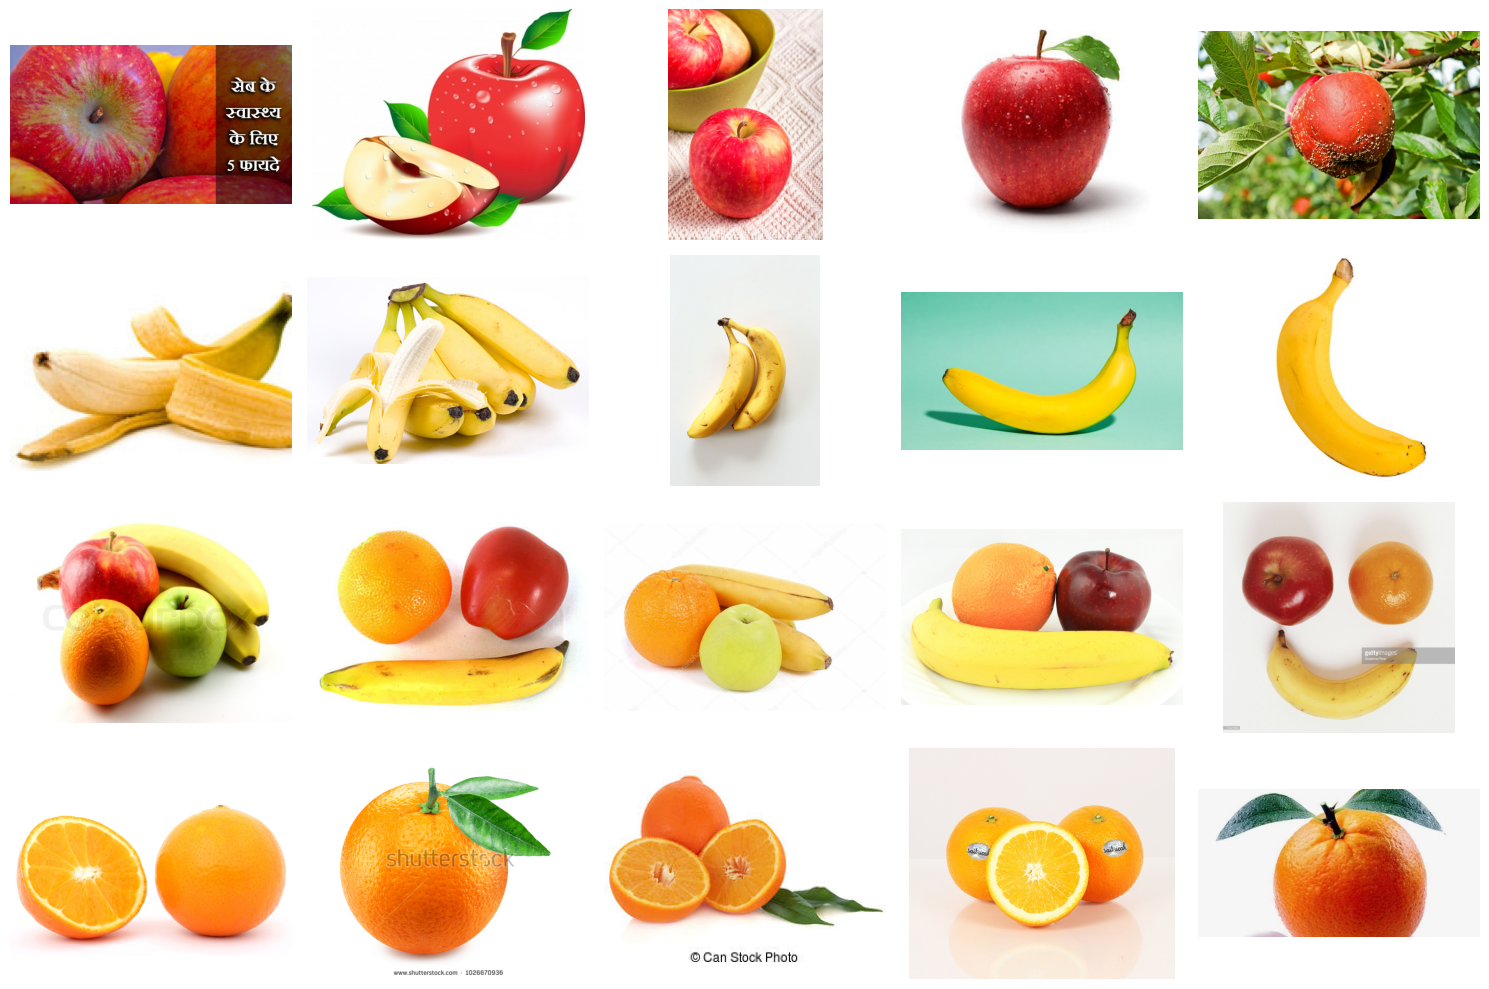

In [36]:
# Data loading helper functions
def load_filepaths(target_dir):
    paths = []
    for root, _, files in os.walk(target_dir):
        for file in files:
            if file.endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(root, file))
    return paths

def prepare_data(target_dir):
    filepaths = []
    labels = []
    class_names = os.listdir(target_dir)
    class_names = [d for d in class_names if os.path.isdir(os.path.join(target_dir, d))]
    class_names.sort()
    class_to_idx = {cls_name: idx for idx, cls_name in enumerate(class_names)}

    for cls_name in class_names:
        cls_dir = os.path.join(target_dir, cls_name)
        fpaths = load_filepaths(cls_dir)
        labels += [class_to_idx[cls_name]] * len(fpaths)
        filepaths += fpaths

    return np.array(filepaths), torch.tensor(labels), class_names

# Load and explore dataset
train_dir = 'train'
test_dir = 'test'

train_filepaths, train_labels, class_names = prepare_data(train_dir)
test_filepaths, test_labels, _ = prepare_data(test_dir)

print(f"Classes: {class_names}")
print(f"Number of training samples: {len(train_filepaths)}")
print(f"Number of testing samples: {len(test_filepaths)}")

# Visualize sample images from each class
def visualize_samples(filepaths, labels, class_names, n_samples=5):
    fig, axes = plt.subplots(len(class_names), n_samples, figsize=(15, 10))
    for i, class_name in enumerate(class_names):
        class_indices = [idx for idx, label in enumerate(labels) if label == i]
        sampled_indices = np.random.choice(class_indices, n_samples, replace=False)
        for j, idx in enumerate(sampled_indices):
            image = Image.open(filepaths[idx]).convert('RGB')
            axes[i, j].imshow(image)
            axes[i, j].axis('off')
            if j == 0:
                axes[i, j].set_ylabel(class_name, fontsize=12)
    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_samples(train_filepaths, train_labels.numpy(), class_names)

## Data Augmentation

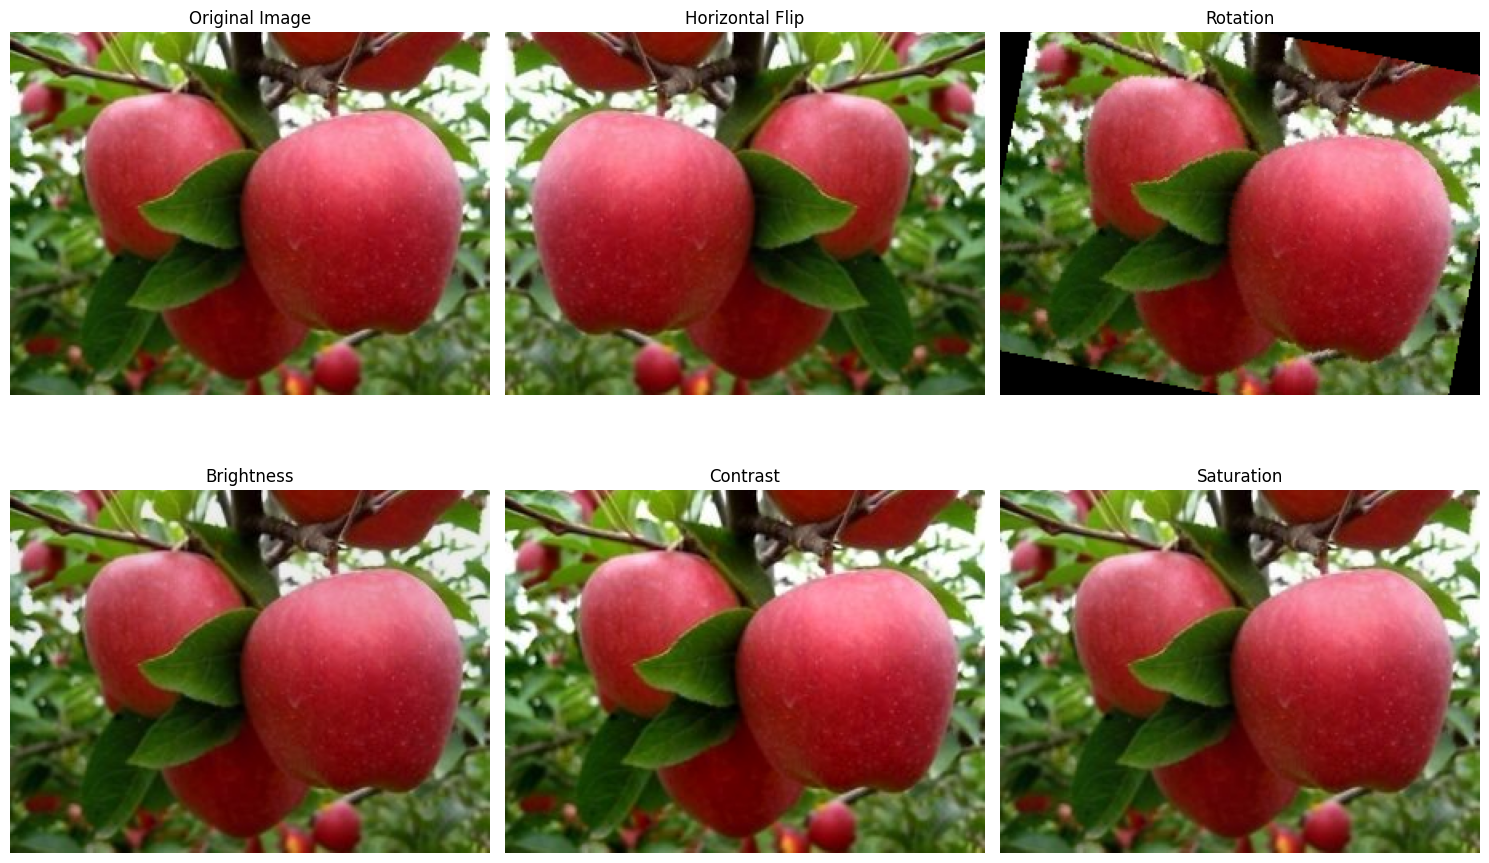

In [37]:
# Image preprocessing and augmentation
def load_images(filepaths, train=True):
    if train:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                              std=[0.229, 0.224, 0.225])
        ])

    tensors = []
    for item in filepaths:
        image = Image.open(item).convert('RGB')
        img_tensor = transform(image)
        tensors.append(img_tensor.unsqueeze(0))

    return torch.cat(tensors, dim=0)

# Visualize data augmentation
def visualize_data_augmentation(filepath):
    image = Image.open(filepath).convert('RGB')
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()

    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    transforms_list = [
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.2),
        transforms.ColorJitter(contrast=0.2),
        transforms.ColorJitter(saturation=0.2)
    ]
    titles = ['Horizontal Flip', 'Rotation', 'Brightness', 'Contrast', 'Saturation']

    for idx, (transform, title) in enumerate(zip(transforms_list, titles), start=1):
        augmented = transform(image)
        axes[idx].imshow(augmented)
        axes[idx].set_title(title)
        axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

# Call the visualization function
visualize_data_augmentation(train_filepaths[0])

## Model Definition
- Batch Normalization: Helps stabilize and accelerate training by normalizing inputs to each layer.
- Increased Depth: More convolutional layers allow the model to capture complex patterns.
- Dropout Layers: Prevent overfitting by randomly omitting neurons during training.
- Max Pooling: Reduces spatial dimensions, enabling computation over larger receptive fields.

In [38]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes=4):
        super(ImprovedCNN, self).__init__()
        self.features = nn.Sequential(
            # Convolutional Layer 1
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Convolutional Layer 2
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            # Convolutional Layer 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )

        self.classifier = nn.Sequential(
            nn.Linear(128 * 8 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

## Training and Validation

In [39]:
# Training and validation
def train(model, criterion, optimizer, train_filepaths, train_labels,
          val_filepaths, val_labels, device, batch_size=32, n_epochs=10):
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3)
    best_loss = float('inf')
    patience = 5
    patience_counter = 0

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        model.train()
        running_loss = 0.0
        correct_preds = 0
        total_samples = len(train_filepaths)

        for i in range(0, total_samples, batch_size):
            batch_filepaths = train_filepaths[i:i + batch_size]
            batch_labels = train_labels[i:i + batch_size]

            inputs = load_images(batch_filepaths, train=True).to(device)
            labels = batch_labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()

        epoch_loss = running_loss / total_samples
        epoch_acc = correct_preds / total_samples * 100
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        val_loss, val_acc = validate(model, criterion, val_filepaths, val_labels, device, batch_size)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        scheduler.step(val_loss)

        if val_loss < best_loss:
            best_loss = val_loss
            patience_counter = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print("Early stopping triggered")
                break

    return train_losses, train_accuracies, val_losses, val_accuracies

# Plot training metrics
def plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(14, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.tight_layout()
    plt.show()

In [40]:
def validate(model, criterion, val_filepaths, val_labels, device, batch_size=32):
    """
    Validate the model on validation data.

    Arguments:
        model: The CNN model to validate
        criterion: Loss function
        val_filepaths: File paths for validation images
        val_labels: Corresponding labels for validation data
        device: The device (CPU/GPU) to use for validation
        batch_size: Number of samples per batch

    Returns:
        val_loss: Average validation loss
        val_acc: Validation accuracy (percentage)
    """
    model.eval()  # Set model to evaluation mode
    running_loss = 0.0
    correct_preds = 0
    total_samples = len(val_filepaths)

    with torch.no_grad():  # Disable gradient calculations for validation
        for i in range(0, total_samples, batch_size):
            batch_filepaths = val_filepaths[i:i + batch_size]
            batch_labels = val_labels[i:i + batch_size]

            # Load and preprocess batch
            inputs = load_images(batch_filepaths, train=False).to(device)
            labels = batch_labels.to(device)

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Calculate running loss and accuracy
            running_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            correct_preds += torch.sum(preds == labels).item()

    # Compute average loss and accuracy
    val_loss = running_loss / total_samples
    val_acc = (correct_preds / total_samples) * 100

    return val_loss, val_acc

## Testing and Evaluation

In [41]:
def test(model, test_filepaths, test_labels, device, class_names, batch_size=32):
    """
    Evaluate the trained model on the test dataset.

    Arguments:
        model: Trained CNN model.
        test_filepaths: Filepaths for test images.
        test_labels: Corresponding labels for test data.
        device: Device to run the model on (CPU/GPU).
        class_names: List of class names for the dataset.
        batch_size: Batch size for testing.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for i in range(0, len(test_filepaths), batch_size):
            batch_filepaths = test_filepaths[i:i + batch_size]
            inputs = load_images(batch_filepaths, train=False).to(device)
            labels = test_labels[i:i + batch_size].to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Generate confusion matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

    # Print classification report
    print("\nPrecision, Recall, F1-score per class:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Visualize predictions
    visualize_predictions(test_filepaths, all_labels, all_preds, class_names)

def visualize_predictions(filepaths, labels, preds, class_names, n_samples=5):
    """
    Visualize random predictions from the test set.

    Arguments:
        filepaths: List of test image file paths.
        labels: True labels.
        preds: Predicted labels.
        class_names: List of class names.
        n_samples: Number of samples to visualize.
    """
    indices = np.random.choice(len(filepaths), n_samples, replace=False)
    plt.figure(figsize=(15, 5))
    for i, idx in enumerate(indices):
        image = Image.open(filepaths[idx]).convert('RGB')
        plt.subplot(1, n_samples, i + 1)
        plt.imshow(image)
        true_label = class_names[labels[idx]]
        pred_label = class_names[preds[idx]]
        color = 'green' if true_label == pred_label else 'red'
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

Using device: mps

Starting training...


/Users/benben/.pyenv/versions/3.12.4/envs/benmain/lib/python3.12/site-packages/PIL/Image.py:1056: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


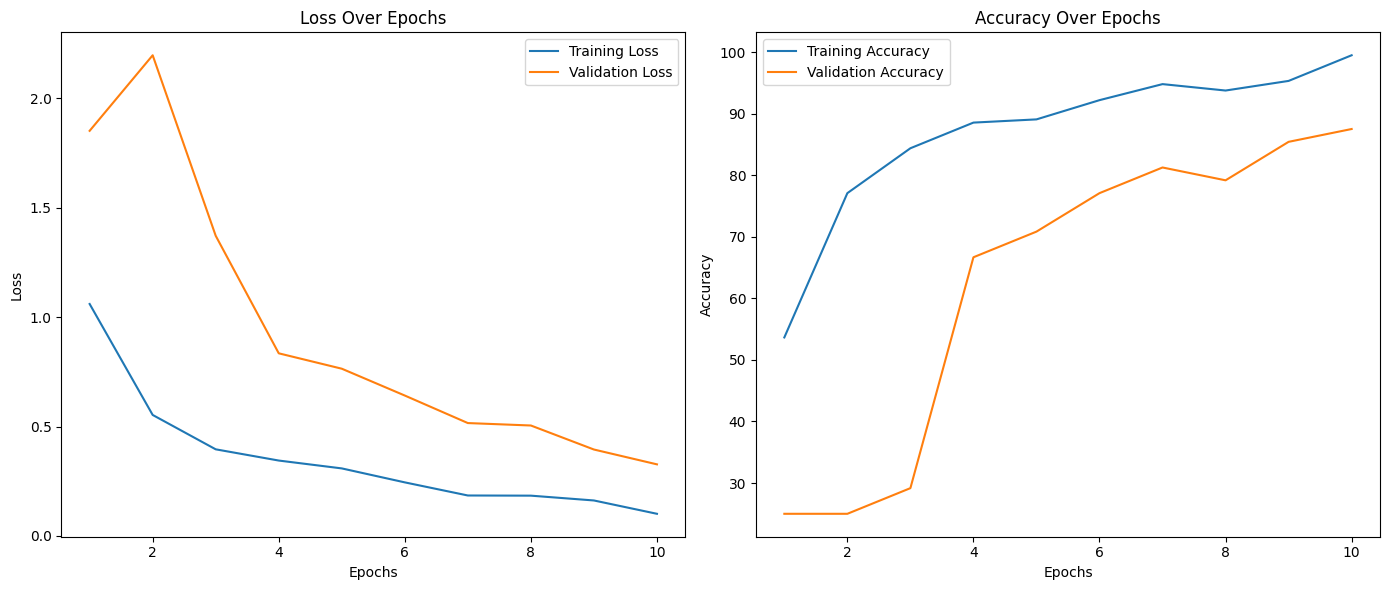


Training complete. Loading best model for testing...

Evaluating on test set...


/var/folders/44/h28k13vj4p797sdf4zqj84t80000gn/T/ipykernel_32752/3612916323.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model

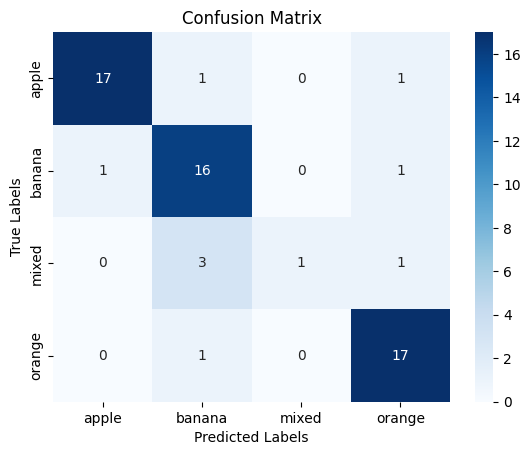


Precision, Recall, F1-score per class:
              precision    recall  f1-score   support

       apple       0.94      0.89      0.92        19
      banana       0.76      0.89      0.82        18
       mixed       1.00      0.20      0.33         5
      orange       0.85      0.94      0.89        18

    accuracy                           0.85        60
   macro avg       0.89      0.73      0.74        60
weighted avg       0.87      0.85      0.83        60



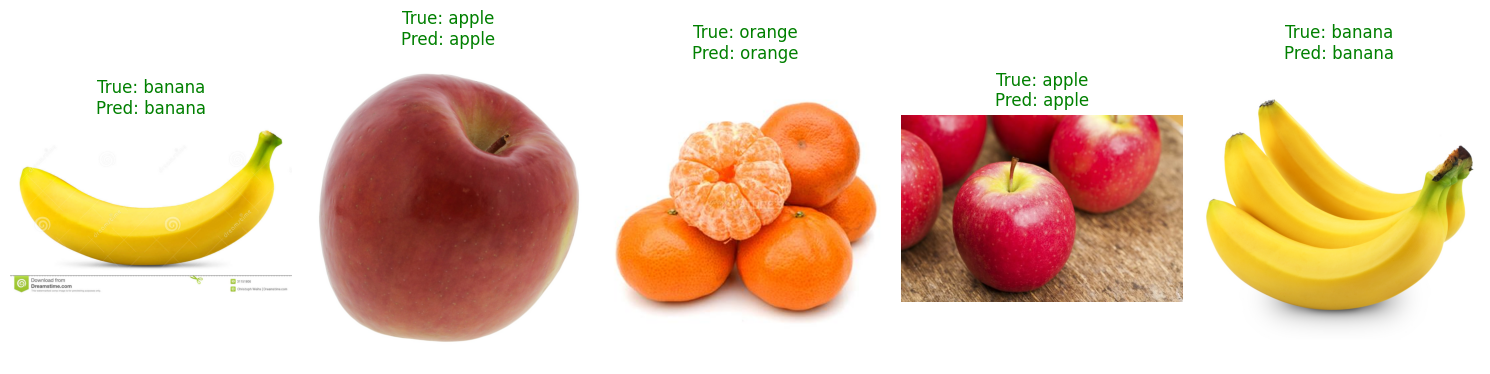


Workflow complete. Saving final model...


In [45]:
# Main workflow
def main():
    # Set random seed for reproducibility
    torch.manual_seed(42)
    np.random.seed(42)
    LEARNING_RATE = 0.0005

    # Device configuration
    # Apple silicon macbook MPS (Metal Performance Shaders)
    device = torch.device('mps' if torch.mps.is_available else 'cpu')
    print(f"Using device: {device}")

    # Initialize model
    model = ImprovedCNN(num_classes=len(class_names)).to(device)

    # Define loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)

    # Split training data into train/validation sets
    train_size = int(0.8 * len(train_filepaths))
    indices = np.random.permutation(len(train_filepaths))
    train_indices = indices[:train_size]
    val_indices = indices[train_size:]

    train_paths = train_filepaths[train_indices]
    train_labs = train_labels[train_indices]
    val_paths = train_filepaths[val_indices]
    val_labs = train_labels[val_indices]

    print("\nStarting training...")
    train_losses, train_accuracies, val_losses, val_accuracies = train(
        model, criterion, optimizer, train_paths, train_labs,
        val_paths, val_labs, device, batch_size=32, n_epochs=10
    )

    # Plot training progress
    plot_metrics(train_losses, val_losses, train_accuracies, val_accuracies)

    print("\nTraining complete. Loading best model for testing...")
    # Load the best model
    model.load_state_dict(torch.load('best_model.pth'))

    print("\nEvaluating on test set...")
    # Test the model
    test(model, test_filepaths, test_labels, device, class_names)

    print("\nWorkflow complete. Saving final model...")
    # Save the trained model
    torch.save(model.state_dict(), 'final_model.pth')

# Run the main function
if __name__ == "__main__":
    main()